# Unsupervised Anomaly Detection using Autoencoders for Predictive Maintenance

This project detects anomalies in machine vibration signals using an autoencoder trained on the NASA IMS Bearing dataset. By learning what “normal” looks like, it identifies unusual behavior without needing labeled data. The project simulates predictive maintenance used in industrial systems.


## Objective

Train an unsupervised autoencoder on normal machine sensor data to detect faults by measuring reconstruction error. This mimics real predictive maintenance use cases.


## Dataset Overview

The dataset used in this project is the NASA IMS Bearing Dataset (Set 1), which contains high-frequency vibration data collected from four bearings under simulated operating conditions. Each recording captures:

*   Sampling rate: 20,480 samples per second per file
*   Number of channels: 8 (corresponding to 4 bearings measured in both horizontal and vertical directions)
*   Sensor layout: Each bearing is monitored using two accelerometers positioned orthogonally (X and Y axes)


## Preprocessing Steps

To make the data suitable for deep learning, we applied the following preprocessing steps:

* Window slicing: The continuous signal was divided into fixed-size windows (e.g., 100 samples per window) to create time-series segments for training and evaluation.

* Normalization: Each windowed segment was normalized to have zero mean and unit variance to improve model convergence and generalization.

This structured format facilitates effective training of the autoencoder model for anomaly detection by enabling it to learn patterns of "normal" vibration behavior.

In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used.")
else:
    print("GPU not found. Training will use CPU.")


GPU not found. Training will use CPU.


In [2]:
# # (Optional) Limit TensorFlow to use only the first GPU if multiple GPUs are present
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#         print("Configured to use GPU:", gpus[0])
#     except RuntimeError as e:
#         print("Error setting GPU device:", e)


# loading and windowing NASA Bearing data

In [2]:

# Libraries for handling data and visualization
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
from io import TextIOWrapper

# "NASA IMS Bearing Dataset" downloaded as ZIP
ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/NASA-Bearing-DS.zip"

# Window Slicing
# "Break into equal-length segments (100-sample windows)"
WINDOW_SIZE = 100

# ------------------------------------------------------------
# Load and preprocess signal windows + labels
#--------------------------------------------------------------

def load_signal_windows_with_labels(zip_path, folder="1st_test/", window_size=100, max_files=None, fault_start_index=800):
    all_windows = []
    all_labels = []

    # "Each .txt file records 1 second of vibration data"
    with ZipFile(zip_path, 'r') as archive:
        # Find all .txt files under the specified folder inside ZIP
        file_list = sorted([
            f for f in archive.namelist()
            if f.startswith(folder) and not f.endswith('/')
        ])

        # Limit number of files processed
        if max_files:
            file_list = file_list[:max_files]

        for i, file_name in enumerate(file_list):
            with archive.open(file_name) as f:
                try:
                    # "Each file has 20,480 samples, 8 channels"
                    signal = np.loadtxt(TextIOWrapper(f))  # shape: (20480,) or (20480, 8)

                    # Preprocessing: Normalization
                    # "Normalize the signals"
                    signal = signal.reshape(-1)
                    signal_norm = (signal - np.mean(signal)) / np.std(signal)

                    # Preprocessing: Window Slicing
                    # "Break into 100-sample windows"
                    n_windows = len(signal_norm) // window_size
                    windows = signal_norm[:n_windows * window_size].reshape(n_windows, window_size)

                    # Label each window: 0 = normal, 1 = faulty (based on file index)
                    label = 0 if i < fault_start_index else 1
                    labels = [label] * n_windows

                    all_windows.extend(windows)
                    all_labels.extend(labels)
                except Exception as e:
                    print(f"Skipped {file_name}: {e}")

    return np.array(all_windows), np.array(all_labels)  # Shape: (N, 100), (N,)

#-------------------------------------------------------------
# Load data and labels
# -----------------------------------------------------------

# "Load and preprocess time-series segments"
all_data_windows, true_labels = load_signal_windows_with_labels(
    ZIP_PATH,
    window_size=WINDOW_SIZE,
    fault_start_index=800  # Adjust based on known fault start in the file sequence
)

# Output shapes to confirm
print("Loaded shape:", all_data_windows.shape)
print("Label shape :", true_labels.shape)
print("Unique labels:", np.unique(true_labels, return_counts=True))


Loaded shape: (3531528, 100)
Label shape : (3531528,)
Unique labels: (array([0, 1]), array([1310400, 2221128]))


## Model Architecture: 1D Autoencoder

To detect anomalies in the vibration signals, we implemented a 1D autoencoder which is a type of neural network specifically designed for unsupervised learning of compressed representations and reconstruction.

The architecture consists of the following components:

* Input Layer: Each input is a fixed-length window of the vibration signal, typically containing 100 consecutive samples representing a short time segment of the sensor data.

* Encoder: A series of fully connected (dense) layers that progressively reduce the dimensionality of the input signal. This process captures the most relevant features of normal operating behavior while compressing the input into a lower-dimensional representation.

* Latent (Bottleneck) Layer: This central layer represents the compressed form of the input. It serves as the learned encoding that the model uses to reconstruct the original signal. It ideally captures the underlying structure of normal patterns in the data.

* Decoder: The decoder mirrors the encoder structure, using fully connected layers to expand the latent representation back to the original input size. It attempts to reconstruct the input signal as closely as possible.

* Loss Function: The model is trained to minimize the Mean Squared Error (MSE) between the original and reconstructed signals. Higher reconstruction error typically indicates an anomaly, as the model has difficulty reconstructing patterns that has not seen during training such as faulty behavior.

This autoencoder architecture allows the system to learn and represent the "normal" behavior of the machinery, making it well-suited for identifying deviations and potential faults in an unsupervised manner.

Input shape for training: (10000, 100)
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1506 - val_loss: 1.0278
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9851 - val_loss: 0.9771
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9280 - val_loss: 0.9447
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9028 - val_loss: 0.9295
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8972 - val_loss: 0.9180
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.8799 - val_loss: 0.9078
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8676 - val_loss: 0.8996
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8684 - val_loss: 0.8915
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8536 - val_loss: 0.8855
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8452 - val_loss: 0.8810
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8500 - val_loss: 0.8776
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━

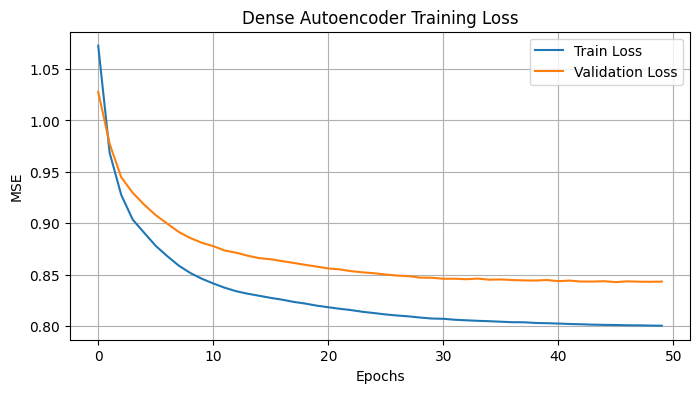

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.callbacks import EarlyStopping

# Prepare training data
sample_windows = all_data_windows[:10000]  # Use first 10k samples
# Input is (100,), no need for extra dimension
print("Input shape for training:", sample_windows.shape)

# Define Dense Autoencoder Architecture
input_layer = Input(shape=(100,))  # 100-sample time window

# === Encoder ===
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
encoded = Dense(16, activation='relu', name='bottleneck_layer')(x) # Latent bottleneck

# === Decoder ===
x = Dense(32, activation='relu')(encoded)
x = Dense(64, activation='relu')(x)
decoded = Dense(100, activation='sigmoid')(x)  # Reconstruct original signal

# Compile the model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(
    sample_windows, sample_windows,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)

# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Dense Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


# Detect Anomalies

In [29]:
def batched_reconstruction(model, data, batch_size=10000):
    reconstructed_all = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        reconstructed_batch = model.predict(batch)
        reconstructed_all.append(reconstructed_batch)
    return np.vstack(reconstructed_all)

subset_data = all_data_windows[:50000]

# Batched reconstruction
reconstructed = batched_reconstruction(autoencoder, subset_data)

# Calculate anomaly scores
anomaly_scores = np.mean(np.square(subset_data - reconstructed), axis=1)

# Define threshold (e.g., 99th percentile)
# threshold = np.percentile(anomaly_scores, 99)
threshold = np.percentile(anomaly_scores, 40)  ## set threshold to 40 after looking Unique labels: (array([0, 1]), array([1310400, 2221128]))
print(f"Anomaly detection threshold: {threshold:.5f}")

predicted_labels = (anomaly_scores > threshold).astype(int)

# Identify top anomalies

print(f"Total Anomalies detected: {np.sum(predicted_labels)} out of  {len(predicted_labels)}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Anomaly detection threshold: 0.65157
Total Anomalies detected: 30000 out of  50000


## Stratified Sampling Code for Balanced Evaluation

In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure the labels (0 = normal, 1 = anomaly)
# true_labels must already be defined and match the length of your data
assert len(true_labels) == len(all_data_windows)

print (len(true_labels))

# Stratified sampling (e.g., 20% sample with same class ratio)
subset_data, _, subset_labels, _ = train_test_split(
    all_data_windows,
    true_labels,
    test_size=0.8,
    stratify=true_labels,
    random_state=42
)


# Perform reconstruction and anomaly detection on subset
reconstructed = batched_reconstruction(autoencoder, subset_data)
anomaly_scores = np.mean(np.square(subset_data - reconstructed), axis=1)
threshold = np.percentile(anomaly_scores, 40)
predicted_labels = (anomaly_scores > threshold).astype(int)
print(f"Anomaly detection threshold: {threshold:.5f}")
print(f"Total Anomalies detected: {np.sum(predicted_labels)} out of  {len(predicted_labels)}")




3531528
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 

## Evaluation Metrics

To assess the performance of the anomaly detection model, we used a combination of classification and visualization-based metrics that reflect how well the model distinguishes between normal and faulty behavior.

The following metrics were employed:

###  Precision, Recall, and F1-score

These metrics provide a detailed breakdown of the model’s classification performance.

* Precision measures how many of the samples flagged as anomalies were actually faulty.

* Recall indicates how many of the actual faulty samples were correctly identified.

* F1-score is the harmonic mean of precision and recall, offering a balanced metric when both false positives and false negatives are important.
These metrics are computed by comparing predicted anomaly labels (based on reconstruction error thresholding) with known faulty samples.

### ROC Curve and AUC (Area Under Curve)

The Receiver Operating Characteristic (ROC) curve plots the true positive rate (recall) against the false positive rate at various threshold settings.
The AUC quantifies the model’s ability to distinguish between normal and abnormal samples. A higher AUC indicates better discriminative power of the model.

### Confusion Matrix

A confusion matrix is used to visualize the number of true positives, true negatives, false positives, and false negatives.
It helps identify the types of errors the model is making and provides a direct way to understand misclassifications in anomaly detection.

By combining these evaluation metrics, we can gain a comprehensive view of the model's strengths and limitations in detecting equipment faults from vibration data.


 Classification Metrics
Precision : 0.6304 – % of predicted anomalies that are truly faulty
Recall    : 0.6014 – % of actual faults correctly identified
F1-Score  : 0.6155   – Harmonic mean of precision and recall
Accuracy  : 0.5275 – Overall correct predictions (both normal and faulty)

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.3732    0.4023    0.3872    262080
           1     0.6304    0.6014    0.6155    444225

    accuracy                         0.5275    706305
   macro avg     0.5018    0.5019    0.5014    706305
weighted avg     0.5350    0.5275    0.5308    706305



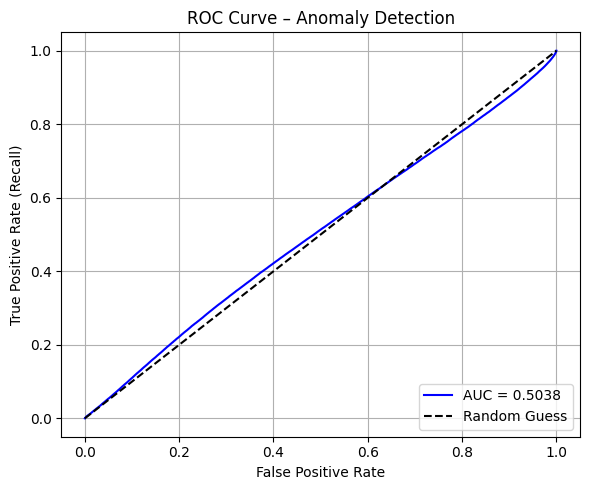


ROC AUC Score: 0.5038 – Higher indicates the better separation between normal and faulty samples


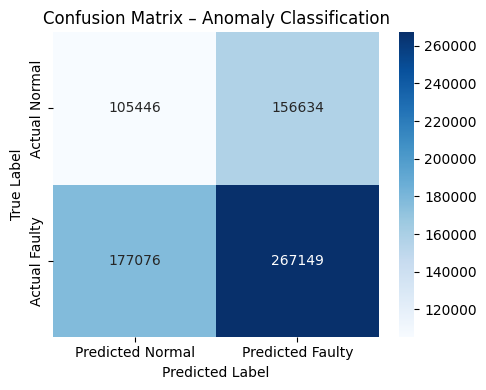


 Confusion Matrix Breakdown:
True Negatives : 105446  – Correctly predicted normal samples
False Positives: 156634  – Normal samples incorrectly flagged as anomalies
False Negatives: 177076  – Faulty samples missed by the model
True Positives : 267149  – Correctly predicted faulty samples


In [34]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,accuracy_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# - true_labels       → shape (N,)
# - predicted_labels  → shape (N,)
# - anomaly_scores    → shape (N,) from reconstruction errors

# Need to ensure true labels match the predicted shape
# new_labels = true_labels[:len(predicted_labels)]


# ------------------------------------------------
# Classification Metrics
#-------------------------------------------------
# print(classification_report(subset_labels, predicted_labels))
precision = precision_score(subset_labels, predicted_labels)
recall = recall_score(subset_labels, predicted_labels)
f1 = f1_score(subset_labels, predicted_labels)
accuracy = accuracy_score(subset_labels, predicted_labels)

print("\n Classification Metrics")
print(f"Precision : {precision:.4f} – % of predicted anomalies that are truly faulty")
print(f"Recall    : {recall:.4f} – % of actual faults correctly identified")
print(f"F1-Score  : {f1:.4f}   – Harmonic mean of precision and recall")
print(f"Accuracy  : {accuracy:.4f} – Overall correct predictions (both normal and faulty)")

print("\nDetailed Classification Report:")
print(classification_report(subset_labels, predicted_labels, digits=4))

# ------------------------------------------------
# ROC Curve and AUC
# -----------------------------------------------
fpr, tpr, _ = roc_curve(subset_labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve – Anomaly Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f} – Higher indicates the better separation between normal and faulty samples")

# -------------------------------------------------
# Confusion Matrix
# -------------------------------------------------
cm = confusion_matrix(subset_labels, predicted_labels)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted Normal", "Predicted Faulty"],
            yticklabels=["Actual Normal", "Actual Faulty"])
plt.title("Confusion Matrix – Anomaly Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\n Confusion Matrix Breakdown:")
print(f"True Negatives : {tn}  – Correctly predicted normal samples")
print(f"False Positives: {fp}  – Normal samples incorrectly flagged as anomalies")
print(f"False Negatives: {fn}  – Faulty samples missed by the model")
print(f"True Positives : {tp}  – Correctly predicted faulty samples")


## Visualization and Reporting

Effective visualization is critical for interpreting model behavior and validating its performance in real-world scenarios. In this project, I have implemented several visualization techniques to analyze reconstruction quality, anomaly detection accuracy, and latent space behavior.

The following visualizations were generated:

###  Histogram of Reconstruction Error
The histograms of reconstruction errors for both normal and faulty samples helps to visualize the natural separation between low-error (normal) and high-error (anomalous) signals, and supports the threshold selection for anomaly detection.

### Timeline of Detected Anomalies
Anomalies were mapped back to their original time indices and plotted on a timeline. This visualization shows when and where faults begin to emerge in the dataset, allowing for easier correlation with known machine failure events.

### ROC Curve and Confusion Matrix
The ROC curve provides an overview of the model's discriminative performance across different thresholds, while the confusion matrix offers a direct view of classification outcomes such as true positives, false positives, true negatives, and false negatives.

### Latent Space Visualization (e.g,t-SNE)
To better understand how the model internally represents the data, we applied dimensionality reduction techniques like t-SNE to the latent representations from the autoencoder. This visualization reveals whether the model clusters normal and abnormal samples distinctly in the learned embedding space.

These visual tools not only support quantitative evaluation but also enhance the interpretability of the model, making it easier to diagnose, debug, and trust its predictions

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, confusion_matrix

# -------------------------------------------------
# Histogram of Reconstruction Error
# --------------------------------------------------
def plot_reconstruction_error_hist(anomaly_scores, true_labels):
    normal_scores = anomaly_scores[true_labels == 0]
    faulty_scores = anomaly_scores[true_labels == 1]

    plt.figure(figsize=(8, 5))
    plt.hist(normal_scores, bins=50, alpha=0.6, label="Normal", color="green")
    plt.hist(faulty_scores, bins=50, alpha=0.6, label="Faulty", color="red")
    plt.axvline(np.percentile(anomaly_scores, 99), color="black", linestyle="--", label="Threshold (40th%)")
    plt.title("Histogram of Reconstruction Error")
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Timeline of Detected Anomalies
# -------------------------------------------------
def plot_anomaly_timeline(anomaly_scores, predicted_labels, threshold):
    plt.figure(figsize=(12, 3))
    plt.plot(anomaly_scores, color='gray', alpha=0.6, label="Reconstruction Error")
    plt.scatter(np.where(predicted_labels == 1)[0],
                anomaly_scores[predicted_labels == 1],
                color='red', label="Detected Anomalies", s=10)
    plt.axhline(threshold, color='black', linestyle='--', label="Threshold")
    plt.title("Timeline of Detected Anomalies")
    plt.xlabel("Window Index (Time)")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------
# ROC Curve
# -----------------------------------------------
def plot_roc_curve(true_labels, anomaly_scores):
    fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title("ROC Curve – Anomaly Detection")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------
# Confusion Matrix
# -----------------------------------------------
def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Predicted Normal", "Predicted Faulty"],
                yticklabels=["Actual Normal", "Actual Faulty"])
    plt.title("Confusion Matrix – Anomaly Classification")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------
# Latent Space t-SNE
# ----------------------------------------------
from tensorflow.keras.models import Model

def plot_latent_tsne(autoencoder, all_data_windows, true_labels, max_points=3000):
    # Create encoder model
    encoder = Model(inputs=autoencoder.input,
                    outputs=autoencoder.get_layer('bottleneck_layer').output)

    # Subset for t-SNE
    data = all_data_windows[:max_points]
    labels = true_labels[:max_points]

    # Get latent encodings
    latent = encoder.predict(data, verbose=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(latent)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                c=labels, cmap="coolwarm", alpha=0.6)
    plt.title("t-SNE Projection of Latent Space")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.colorbar(label="True Label (0=Normal, 1=Faulty)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


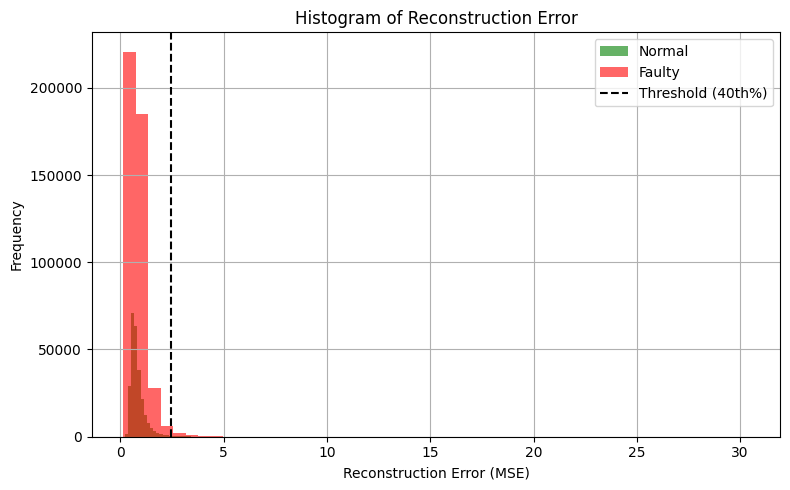

/tmp/ipython-input-1839267800.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


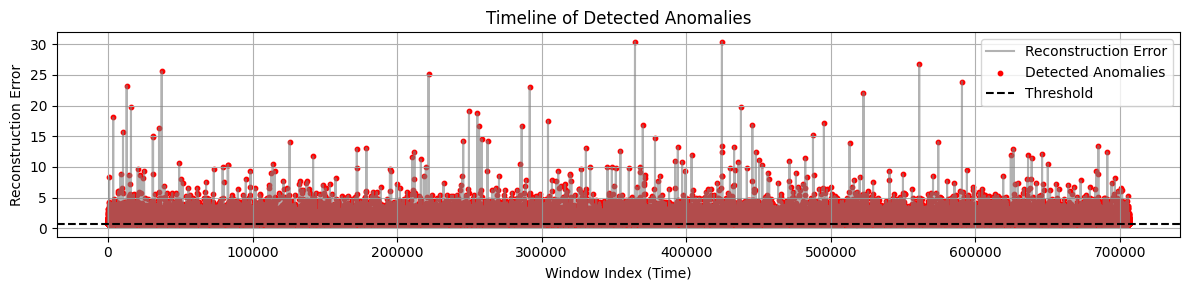

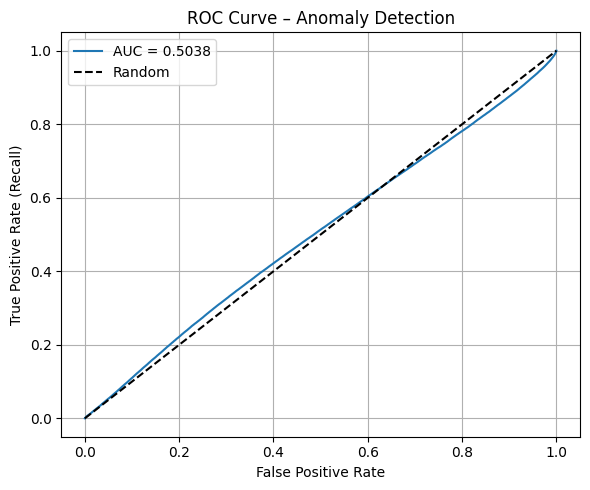

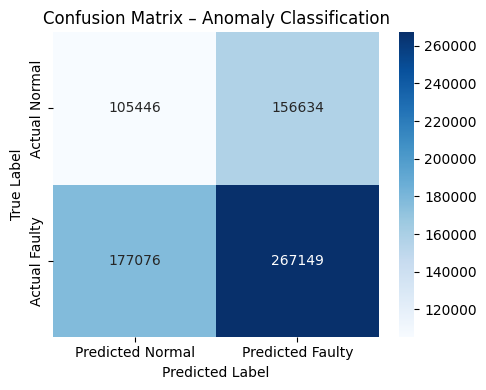

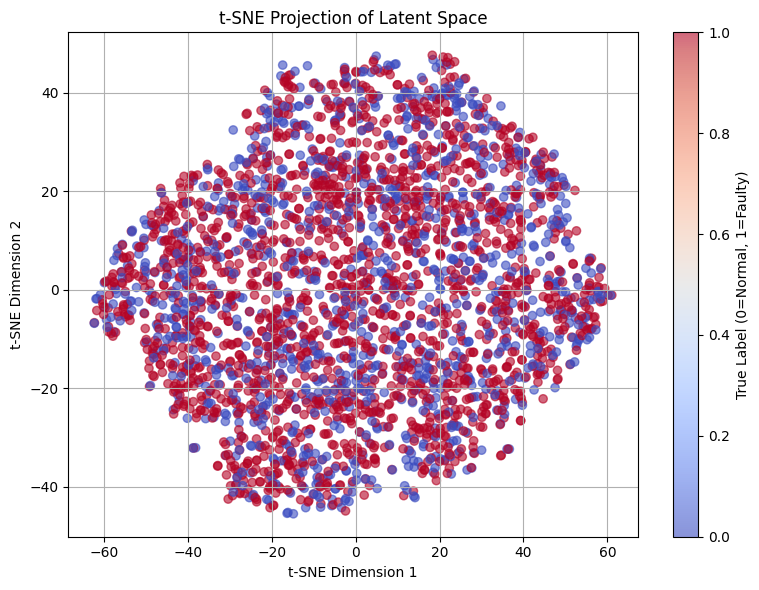

In [42]:
# Ensure predictions and scores already exist
# predicted_labels = (anomaly_scores > threshold).astype(int)

plot_reconstruction_error_hist(anomaly_scores, subset_labels)
plot_anomaly_timeline(anomaly_scores, predicted_labels, threshold)
plot_roc_curve(subset_labels, anomaly_scores)
plot_confusion_matrix(subset_labels, predicted_labels)
plot_latent_tsne(autoencoder, all_data_windows, subset_labels)


## Connecting to MLOps

If time permits, an exciting direction for extending this project would be to integrate it with modern MLOps (Machine Learning Operations) practices. This would allow the system to better simulate real-world deployment and lifecycle management of machine learning models. Key areas of exploration include:

* Experiment Tracking:
Using tools like MLflow or TensorBoard to log training metrics such as loss curves, reconstruction error trends, and evaluation scores. This enables reproducibility and better understanding of model behavior over time.

* Model Deployment:
Packaging the trained autoencoder into a RESTful API using frameworks like FastAPI or Flask, allowing external systems to send new data and receive anomaly predictions in real-time.

* Containerization:
Employing Docker to containerize the entire application—code, dependencies, and environment settings—facilitating seamless deployment across different platforms and cloud services.

* Monitoring and Retraining:
Simulating a pipeline where the system monitors incoming data for drift or unseen anomaly patterns, and triggers model retraining or fine-tuning as needed to adapt to evolving conditions.

Integrating these components would move the project from a research prototype to a production-ready anomaly detection system, aligned with real-world operational needs.

## Multimodal Integration with Large Language Models (LLMs)

To enhance the interpretability and usability of the anomaly detection system, I have integrated with multimodal large language models (LLMs) that can process both text and visual inputs. Our intention is to leverage open-source models available on Hugging Face, such as LLaVA, BLIP-2, and other vision-language models.

For instance, after generating signal plots that highlight reconstruction errors or timelines of detected anomalies, these plots can be passed as images to a multimodal LLM. The model can then generate natural language explanations—identifying unusual patterns, estimating when a fault may have begun, or providing intuitive interpretations of the signal behavior.

This integration would support automated, human-readable anomaly reports, making the system more accessible to non-technical users. It opens the door to intelligent visual diagnostics, natural language summaries, and interactive interfaces for system monitoring and decision support.



In [9]:
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------
# Generate and Save a Signal Plot
# ------------------------------------------------
def save_anomaly_timeline_plot(anomaly_scores, predicted_labels, threshold, filename="anomaly_timeline.png"):
    plt.figure(figsize=(12, 3))
    plt.plot(anomaly_scores, color='gray', alpha=0.6, label="Reconstruction Error")
    plt.scatter(np.where(predicted_labels == 1)[0],
                anomaly_scores[predicted_labels == 1],
                color='red', s=10, label="Detected Anomalies")
    plt.axhline(threshold, color='black', linestyle='--', label="Threshold")
    plt.title("Timeline of Detected Anomalies")
    plt.xlabel("Window Index")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Plot saved to {filename}")

# ------------------------------------------------
# Use a Hugging Face Vision-Language Model ( BLIP-2)
# --------------------------------------------------

def interpret_plot_with_llm(image_path, prompt="Explain this anomaly plot:"):
    model_id = "Salesforce/blip2-flan-t5-xl" #"Salesforce/blip2-opt-2.7b"  # We can replace with LLaVA,  etc.

    # Load model and processor
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForVision2Seq.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

    # Generate explanation
    generated_ids = model.generate(**inputs, max_new_tokens=150)
    response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response


In [10]:
# Save anomaly timeline plot
save_anomaly_timeline_plot(anomaly_scores, predicted_labels, threshold)

# Generate caption using multimodal LLM
caption = interpret_plot_with_llm("anomaly_timeline.png", prompt="Describe the anomalies shown in this timeline plot.")
print("\nLLM Explanation:")
print(caption)


Plot saved to anomaly_timeline.png


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2160: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and wi

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1614: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens', 'language_model.decoder.embed_tokens']
  warnings.warn(



LLM Explanation:
a trough is a line that is a straight line that is a straight line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a line that is a


In [ ]:
# Generate caption using multimodal LLM
caption = interpret_plot_with_llm("anomaly_timeline.png", prompt="This is a time-series anomaly detection plot showing reconstruction errors over time.Red dots indicate detected anomalies. Black line is the threshold. Summarize what this plot reveals about system faults.")
print("\nLLM Explanation:")
print(caption)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]